In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import pandas as pd
import time
from string import ascii_lowercase
from scipy import special
from scipy.constants import mu_0, epsilon_0
import empymod
# SimPEG, discretize/
import discretize
from discretize import utils
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG.electromagnetics import resistivity as dc
from SimPEG.utils import mkvc, plot_1d_layer_model
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from geoana.em.tdem import ElectricDipoleWholeSpace
from geoana.em.tdem import vertical_magnetic_flux_time_deriv_horizontal_loop
from geoana.em.tdem import diffusion_distance
from geoana.em.tdem import peak_time
from geoana.utils import ndgrid
from pymatsolver import Pardiso
# Machine Epssilon for float
eps = np.finfo(float).eps

C:\Users\81805\AppData\Local\Temp\ipykernel_20800\2943003373.py:15: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  from SimPEG.electromagnetics import time_domain as tdem


In [2]:
import empymod

In [3]:
tx_radius = (3.5)/(np.sqrt(np.pi))
print(f"Cell size: {tx_radius}")

Cell size: 1.9746635424171473


In [4]:
sigma_air = 1e-8
sigma_sea = 3.0
depth_sea = 1000.1
sigma_seabed = 3.0
# sigma_target = np.r_[sigma_sea]
# target_radius = np.r_[0, 0.2]
# target_z = np.r_[0, 0.2]
tx_height = 0
tx_current = 1

In [5]:
#rx_times = [np.linspace(np.log10(e-5), np.log10(8e-3), 20)]
tstrt, tend = 1e-5, 1e-2
print(f'Peak time = {peak_time(z=tx_radius, sigma=sigma_sea):.2e} sec')

print(f'Earliest time = {tstrt:.2e} sec, \
Diffusion Depth: {diffusion_distance(sigma=sigma_sea, time=tstrt):.2e}')

print(f'''Latest time = {tend:.2e} sec, \
Diffusion Depth: {diffusion_distance(sigma=sigma_sea, time=tend):.2e}''')

# Compute transition time from Early to late time
print(f'Transition time between early and late time = {(mu_0 * (tx_radius**2) * sigma_sea) / 4:.5e}')

EarlyTime = mu_0 * sigma_sea * (tx_radius**2) / 4

Peak time = 2.45e-06 sec
Earliest time = 1.00e-05 sec, Diffusion Depth: 2.30e+00
Latest time = 1.00e-02 sec, Diffusion Depth: 7.28e+01
Transition time between early and late time = 3.67500e-06


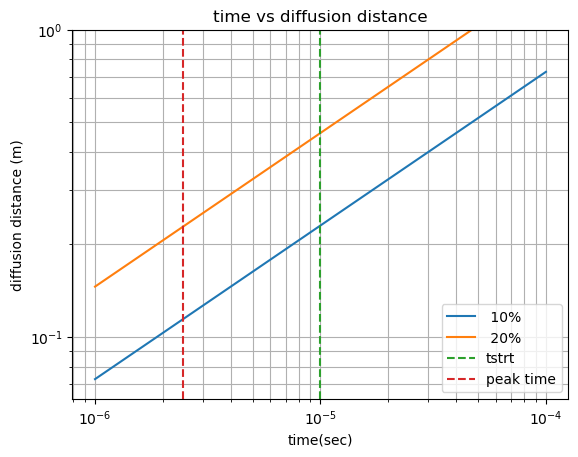

In [6]:
mirginL, mirginR = 10, 10
dttest = np.logspace(np.log10(tstrt/mirginL),np.log10(tstrt*mirginR), 100)
plt.loglog(dttest ,0.1*diffusion_distance(sigma=sigma_sea,time=dttest), color='C0',label=' 10%')
plt.loglog(dttest ,0.2*diffusion_distance(sigma=sigma_sea,time=dttest), color='C1',label=' 20%')
#plt.loglog(dttest ,    diffusion_distance(sigma=sigma_sea,time=dttest),label='100%')
plt.axvline(x=tstrt, color='C2', linestyle='--', label='tstrt')
plt.axvline(x= peak_time(z=tx_radius, sigma=sigma_sea), color='C3', linestyle='--', label='peak time')
plt.xlabel('time(sec)')
plt.ylabel('diffusion distance (m)')
plt.title('time vs diffusion distance')
plt.legend()
plt.grid(True, which="both")
#plt.xlim(left= tstrt/mirginL, right= tstrt*mirginR)
plt.ylim(top=1)
plt.show()

## empymod simulaion 

In [7]:
time_empymod = np.logspace(np.log10(tstrt),np.log10(tend), 101)
nlayers = 1
depth = np.r_[0]
res = np.r_[1/sigma_air, 1/sigma_sea]
#tr_side = 3.5

In [8]:
empymod_model = {
#    'src':  [tr_side/2,tr_side/2, 0,tr_side/2,depth_sea, 1000],
    'src':  [tx_radius, 0, 1000],
#    'rec': [0,0,depth_sea,0,90],
    'rec': [0         , 0, 1000],
    'depth': np.r_[0],
    'freqtime': time_empymod ,
    'signal': 0,
    'ab': 62,
#    'mrec' : True,
    # 'strength': 8,  
    # 'srcpts' : 3, 
    'verb': 0
}

In [9]:
#empymod_bple = empymod.bipole(res=res, **empymod_model)
empymod_dple = empymod.dipole(res=res, **empymod_model)
# 4 side, 5 turns, permeability, area,
coef_adj = 1.0
#empymod_dpred =  empymod_bple*5*coef_adj*mu_0*tr_side**2
empymod_dple *= tx_radius*2*np.pi
empymod_dpred =  empymod_dple*5*coef_adj*mu_0*(np.pi*tx_radius**2)

## Convergence Study

In [10]:
def analytic(time_clc):
    depth = np.r_[0]
    res = np.r_[1/sigma_air, 1/sigma_sea]
    tr_side = 3.5
    
    empymod_model = {
    #    'src':  [tr_side/2,tr_side/2, 0,tr_side/2,depth_sea, 1000],
        'src':  [tx_radius, 0, 1000],
    #    'rec': [0,0,depth_sea,0,90],
        'rec': [0         , 0, 1000],
        'depth': np.r_[0],
        'freqtime': time_clc ,
        'signal': 0,
        'ab': 62,
    #    'mrec' : True,
        # 'strength': 8,  
        # 'srcpts' : 3, 
        'verb': 0
    }

        #empymod_bple = empymod.bipole(res=res, **empymod_model)
    empymod_dple = empymod.dipole(res=res, **empymod_model)
    # 4 side, 5 turns, permeability, area,
    coef_adj = 1.0
    #empymod_dpred =  empymod_bple*5*coef_adj*mu_0*tr_side**2
    empymod_dple *= tx_radius*2*np.pi
    empymod_dpred =  empymod_dple*5*coef_adj*mu_0*(np.pi*tx_radius**2)
    # empymod_bple = empymod.bipole(res=res, **empymod_model)
    # # 4 side, 5 turns, permeability, area,
    # coef_adj = 1.0
    # empymod_dpred =  empymod_bple*5*coef_adj*mu_0*tr_side**2
    return empymod_dpred


In [11]:
def conv_study(mesh, time_steps, tstrt= 1e-5, tend = 1e-2 ):
    model = {}
    m = sigma_air * np.ones(mesh.n_cells)
    m[mesh.cell_centers[:, 2] < depth_sea - tx_height] = sigma_sea
    m[mesh.cell_centers[:, 2] <            -tx_height] = sigma_seabed
    model = m

    steps = np.array([])
    for i in range(len(time_steps)):
        dt, n = time_steps[i]
        step_array = dt * np.ones(n)
        steps = np.concatenate((steps, step_array))
    time_clc = np.cumsum(steps)
    time_clc = time_clc[time_clc < tend+eps ]
    # time_chunk = np.array([step[0] * step[1] for step in time_steps])
    # time_gap = np.cumsum(time_chunk)

    waveform=tdem.sources.StepOffWaveform()
    rx_z = tdem.receivers.PointMagneticFluxTimeDerivative(
        np.r_[0, 0, tx_height], times=time_clc, orientation="z"
    )
    src = tdem.sources.CircularLoop(
        location=np.r_[0, 0, tx_height], radius=tx_radius, receiver_list=[rx_z], waveform=waveform
    )
    survey = tdem.Survey([src])
    sim = tdem.simulation.Simulation3DElectricField(
        mesh=mesh, survey=survey,  solver=Pardiso, time_steps=time_steps,
        t0=0,sigmaMap=maps.IdentityMap(mesh)
    )
    simpeg_sim =sim.dpred(model)[time_clc >= tstrt +time_clc[0] -eps]
    dpred_simpeg = -simpeg_sim*5*np.pi*tx_radius**2

    dpred_time = time_clc -time_clc[0]
    dpred_time = dpred_time[dpred_time >= tstrt-eps]
    # analytic_data = analytic(dpred_time)
    # error_max = np.max(np.abs(dpred_simpeg-analytic_data))
    return dpred_time, dpred_simpeg #, analytic_data, error_max


## Define time steps

In [12]:
cnv_csx = []
cnv_time_step = []
cnv_time = []
cnv_dpred = []
cnv_time_clc = []

time_steps = [None] * 4
mcount = 0

In [13]:
m_tstp = 4
m_csx = 4
time_steps[0] = [(2e-6,  150),  (5e-6,  150),  (2e-5,  150), (5e-5,  150)]
time_steps[1] = [(1e-6,  300),  (3e-6,  300),  (1e-5,  300), (3e-5,  300)]
time_steps[2] = [(5e-7,  500),  (2e-6,  500),  (5e-6,  500), (2e-5,  500)]
time_steps[3] = [(2e-7, 1500),  (5e-7, 1500),  (2e-6, 1500), (5e-6, 1500)]

print(f"Time steps to consider{time_steps}")

Time steps to consider[[(2e-06, 150), (5e-06, 150), (2e-05, 150), (5e-05, 150)], [(1e-06, 300), (3e-06, 300), (1e-05, 300), (3e-05, 300)], [(5e-07, 500), (2e-06, 500), (5e-06, 500), (2e-05, 500)], [(2e-07, 1500), (5e-07, 1500), (2e-06, 1500), (5e-06, 1500)]]


In [14]:
time_gap = np.zeros((m_tstp,4))
for i in range(m_tstp):
      time_chunk = np.array([step[0] * step[1] for step in time_steps[i]])
      time_gap[i,:] = np.cumsum(time_chunk)
print(f"Time gap: {time_gap}")

Time gap: [[0.0003  0.00105 0.00405 0.01155]
 [0.0003  0.0012  0.0042  0.0132 ]
 [0.00025 0.00125 0.00375 0.01375]
 [0.0003  0.00105 0.00405 0.01155]]


## Mesh size 1

In [15]:
csx, csz = tx_radius/4.,tx_radius/4.
ncx, ncz  = 100, 100 
# ncx, ncz  = 200, 200 
pf, npadx, npadz = 1.3 , 26, 26
mesh = discretize.CylindricalMesh(
    [[(csx, ncx), (csx, npadx, pf)], [np.pi*2], [(csz, npadz, -pf), (csz, 2*ncz), (csz, npadz, pf)]], 
    origin = "000"
)
mesh.origin = np.r_[0, 0, -mesh.h[2][:npadz+ncz].sum()]
print(f"Cell size: {csx}, number of cells in center: {ncx}")


Cell size: 0.4936658856042868, number of cells in center: 100


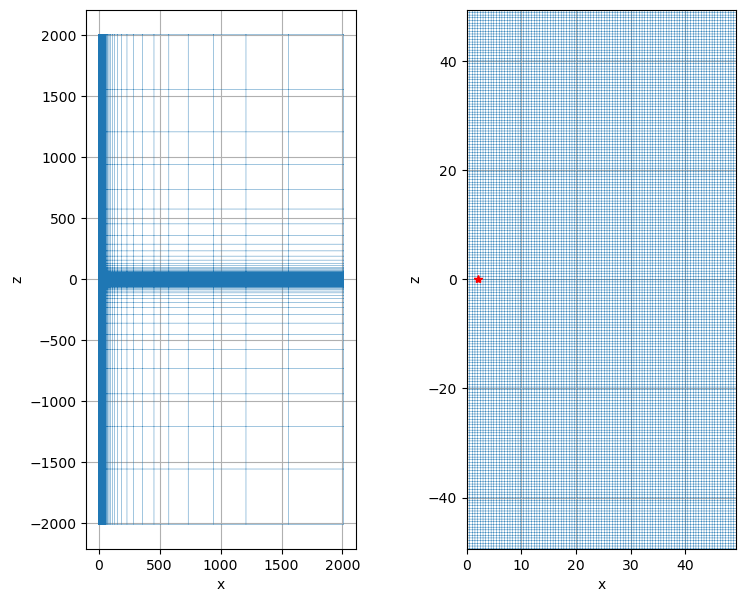

In [16]:
fig, ax = plt.subplots(1,2, figsize=(9,7))
ax[0] = mesh.plot_grid(ax=ax[0], show_it=False, linewidth=0.3)  
ax[0].set_aspect('equal')
ax[1] =  mesh.plot_grid(ax=ax[1], show_it=False, linewidth=0.3)
#ax[1] =  mesh.plot_grid(show_it=True)
ax[1].set_xlim(0.,ncx*csx)
ax[1].set_ylim(-ncz*csz,ncz*csz)
ax[1].set_aspect('equal')
ax[1].plot(tx_radius,0,'r*')



In [17]:
for i in range(m_tstp):
    print("time step", time_steps[i])
    start_time = time.time()
    dpred_time, dpred_simpeg = conv_study(mesh,time_steps[i])
    end_time = time.time()
    elapsed_time = end_time - start_time
    # Print the computational time
    print(f"Computational time: {elapsed_time:.4f} seconds")
    cnv_csx.append(csx)
    cnv_time_step.append(time_steps[i][0][0])
    cnv_time.append(dpred_time)
    cnv_dpred.append(dpred_simpeg)
    cnv_time_clc.append(elapsed_time)    
mcount += m_tstp

time step [(2e-06, 150), (5e-06, 150), (2e-05, 150), (5e-05, 150)]
Computational time: 16.4811 seconds
time step [(1e-06, 300), (3e-06, 300), (1e-05, 300), (3e-05, 300)]
Computational time: 30.8001 seconds
time step [(5e-07, 500), (2e-06, 500), (5e-06, 500), (2e-05, 500)]
Computational time: 54.0431 seconds
time step [(2e-07, 1500), (5e-07, 1500), (2e-06, 1500), (5e-06, 1500)]
Computational time: 184.3241 seconds


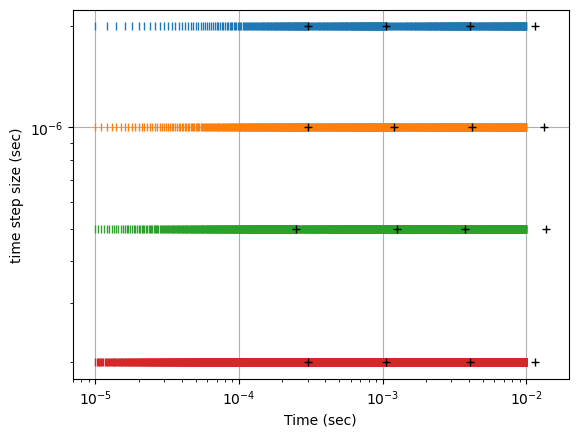

In [18]:
for i in np.arange(m_tstp):
    plt.loglog(cnv_time[i], cnv_time_step[i]*np.ones_like(cnv_time[i]), marker='|', linestyle='None', label=f"dt = {cnv_time_step[i]:.0e}")
    plt.loglog(time_gap[i,:], cnv_time_step[i]*np.ones_like(time_gap[i,:]),color='k', marker='+', linestyle='None')
plt.xlabel("Time (sec)")
plt.ylabel('time step size (sec)')
plt.grid()

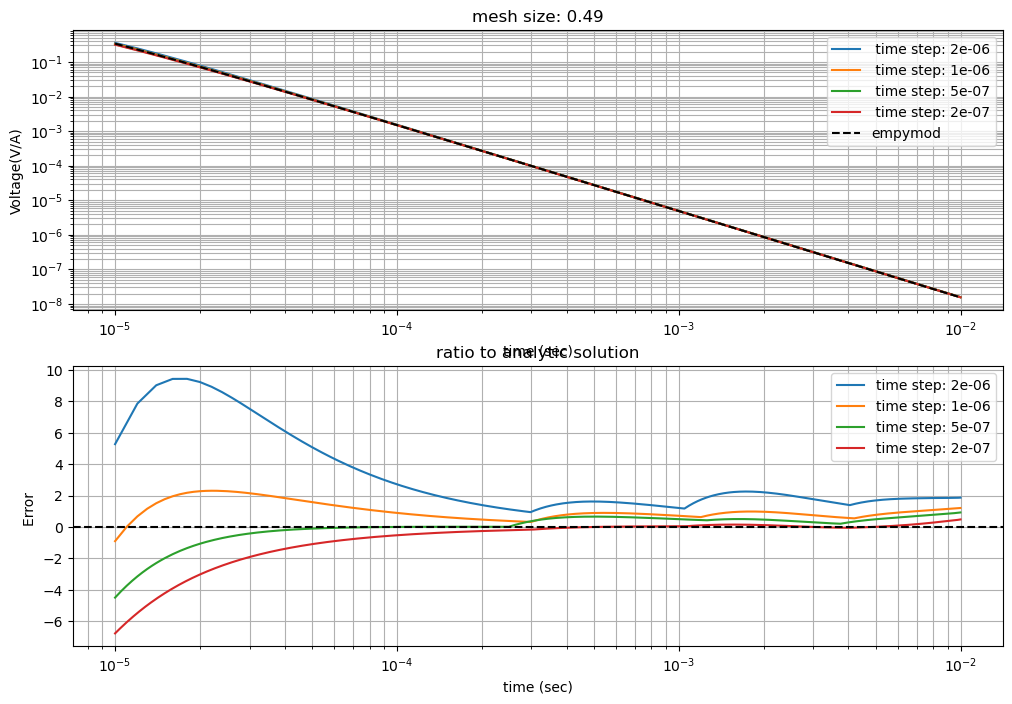

In [19]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
istrt = mcount-m_tstp
for i in np.arange(m_tstp)+istrt:
    ax[0].loglog(cnv_time[i], cnv_dpred[i], label = f" time step: {cnv_time_step[i]:.0e}")
ax[0].loglog(time_empymod, empymod_dpred,'k--',label = "empymod")
ax[0].set_ylabel("Voltage(V/A)")
ax[0].set_title(f"mesh size: {cnv_csx[istrt]:.2f}")
for i in np.arange(m_tstp)+istrt:
    ax[1].semilogx(cnv_time[i],(cnv_dpred[i]/analytic(cnv_time[i])-1)*100, label = f"time step: {cnv_time_step[i]:.0e}")
ax[1].set_title("ratio to analytic solution")
ax[1].axhline(y=0, color='k', linestyle='--')
ax[1].set_ylabel("Error ")

for a in ax:
    a.legend()
    a.set_xlabel("time (sec)")
    a.grid(True, which='both')

## Mesh size 2

In [20]:
csx, csz = tx_radius/5.,tx_radius/5.
ncx, ncz  = 125, 125 
# ncx, ncz  = 200, 200 
pf, npadx, npadz = 1.3 , 28, 28
mesh = discretize.CylindricalMesh(
    [[(csx, ncx), (csx, npadx, pf)], [np.pi*2], [(csz, npadz, -pf), (csz, 2*ncz), (csz, npadz, pf)]], 
    origin = "000"
)
mesh.origin = np.r_[0, 0, -mesh.h[2][:npadz+ncz].sum()]
print(f"Cell size: {csx}, number of cells in center: {ncx}")

Cell size: 0.39493270848342943, number of cells in center: 125


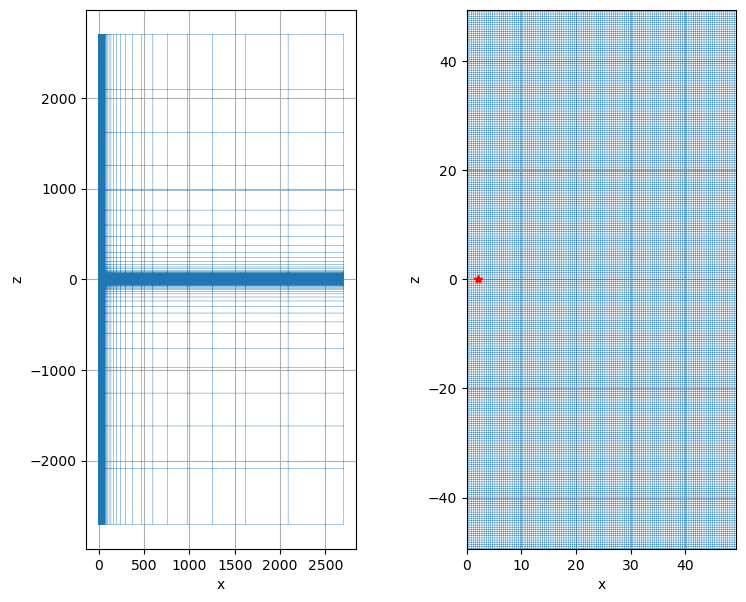

In [21]:
fig, ax = plt.subplots(1,2, figsize=(9,7))
ax[0] = mesh.plot_grid(ax=ax[0], show_it=False, linewidth=0.3)  
ax[0].set_aspect('equal')
ax[1] =  mesh.plot_grid(ax=ax[1], show_it=False, linewidth=0.3)
#ax[1] =  mesh.plot_grid(show_it=True)
ax[1].set_xlim(0.,ncx*csx)
ax[1].set_ylim(-ncz*csz,ncz*csz)
ax[1].set_aspect('equal')
ax[1].plot(tx_radius,0,'r*')

In [22]:
for i in range(m_tstp):
    print("time step", time_steps[i])
    start_time = time.time()
    dpred_time, dpred_simpeg = conv_study(mesh,time_steps[i])
    end_time = time.time()
    elapsed_time = end_time - start_time
    # Print the computational time
    print(f"Computational time: {elapsed_time:.4f} seconds")
    cnv_csx.append(csx)
    cnv_time_step.append(time_steps[i][0][0])
    cnv_time.append(dpred_time)
    cnv_dpred.append(dpred_simpeg)
mcount += m_tstp

time step [(2e-06, 150), (5e-06, 150), (2e-05, 150), (5e-05, 150)]
Computational time: 27.7175 seconds
time step [(1e-06, 300), (3e-06, 300), (1e-05, 300), (3e-05, 300)]
Computational time: 55.4484 seconds
time step [(5e-07, 500), (2e-06, 500), (5e-06, 500), (2e-05, 500)]
Computational time: 86.6672 seconds
time step [(2e-07, 1500), (5e-07, 1500), (2e-06, 1500), (5e-06, 1500)]
Computational time: 305.9068 seconds


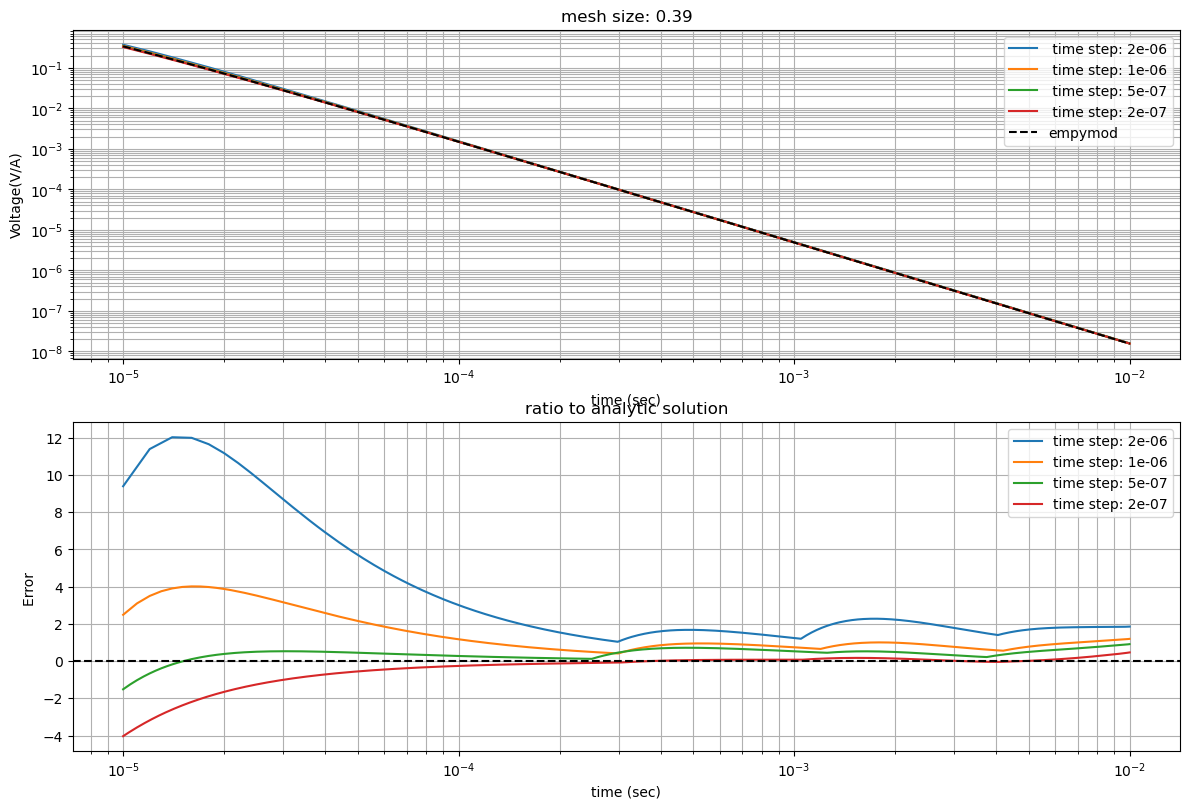

In [23]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
istrt = mcount-m_tstp
for i in np.arange(m_tstp) + istrt:
    ax[0].loglog(cnv_time[i], cnv_dpred[i], label = f" time step: {cnv_time_step[i]:.0e}")
ax[0].loglog(time_empymod, empymod_dpred,'k--',label = "empymod")
ax[0].set_ylabel("Voltage(V/A)")
ax[0].set_title(f"mesh size: {cnv_csx[istrt]:.2f}")
for i in np.arange(m_tstp) + istrt:
    ax[1].semilogx(cnv_time[i],(cnv_dpred[i]/analytic(cnv_time[i])-1)*100, label = f"time step: {cnv_time_step[i]:.0e}")
ax[1].set_title("ratio to analytic solution")
ax[1].axhline(y=0, color='k', linestyle='--')
ax[1].set_ylabel("Error ")
plt.tight_layout()
for a in ax:
    a.legend()
    a.set_xlabel("time (sec)")
    a.grid(True, which='both')

## Mesh size 3

In [24]:
csx, csz = tx_radius/8.,tx_radius/8.
ncx, ncz  = 200, 200 
pf, npadx, npadz = 1.3 , 29, 29
mesh = discretize.CylindricalMesh(
    [[(csx, ncx), (csx, npadx, pf)], [np.pi*2], [(csz, npadz, -pf), (csz, 2*ncz), (csz, npadz, pf)]], 
    origin = "000"
)
mesh.origin = np.r_[0, 0, -mesh.h[2][:npadz+ncz].sum()]
print(f"Cell size: {csx}, number of cells in center: {ncx}")

Cell size: 0.2468329428021434, number of cells in center: 200


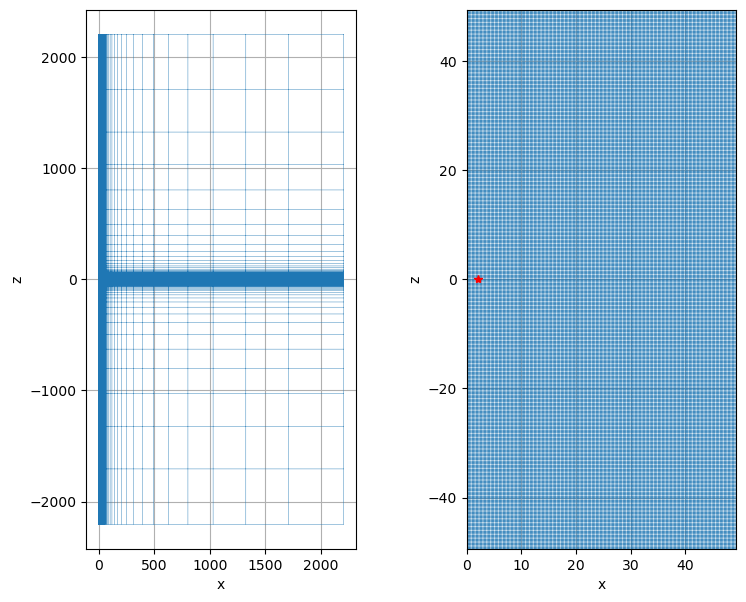

In [25]:
fig, ax = plt.subplots(1,2, figsize=(9,7))
ax[0] = mesh.plot_grid(ax=ax[0], show_it=False, linewidth=0.3)  
ax[0].set_aspect('equal')
ax[1] =  mesh.plot_grid(ax=ax[1], show_it=False, linewidth=0.3)
#ax[1] =  mesh.plot_grid(show_it=True)
ax[1].set_xlim(0.,ncx*csx)
ax[1].set_ylim(-ncz*csz,ncz*csz)
ax[1].set_aspect('equal')
ax[1].plot(tx_radius,0,'r*')

In [26]:
for i in range(m_tstp):
    print("time step", time_steps[i])
    start_time = time.time()
    dpred_time, dpred_simpeg = conv_study(mesh,time_steps[i])
    end_time = time.time()
    elapsed_time = end_time - start_time
    # Print the computational time
    print(f"Computational time: {elapsed_time:.4f} seconds")
    cnv_csx.append(csx)
    cnv_time_step.append(time_steps[i][0][0])
    cnv_time.append(dpred_time)
    cnv_dpred.append(dpred_simpeg)
mcount += m_tstp

time step [(2e-06, 150), (5e-06, 150), (2e-05, 150), (5e-05, 150)]
Computational time: 64.1811 seconds
time step [(1e-06, 300), (3e-06, 300), (1e-05, 300), (3e-05, 300)]
Computational time: 138.8937 seconds
time step [(5e-07, 500), (2e-06, 500), (5e-06, 500), (2e-05, 500)]
Computational time: 218.7241 seconds
time step [(2e-07, 1500), (5e-07, 1500), (2e-06, 1500), (5e-06, 1500)]
Computational time: 1206.3546 seconds


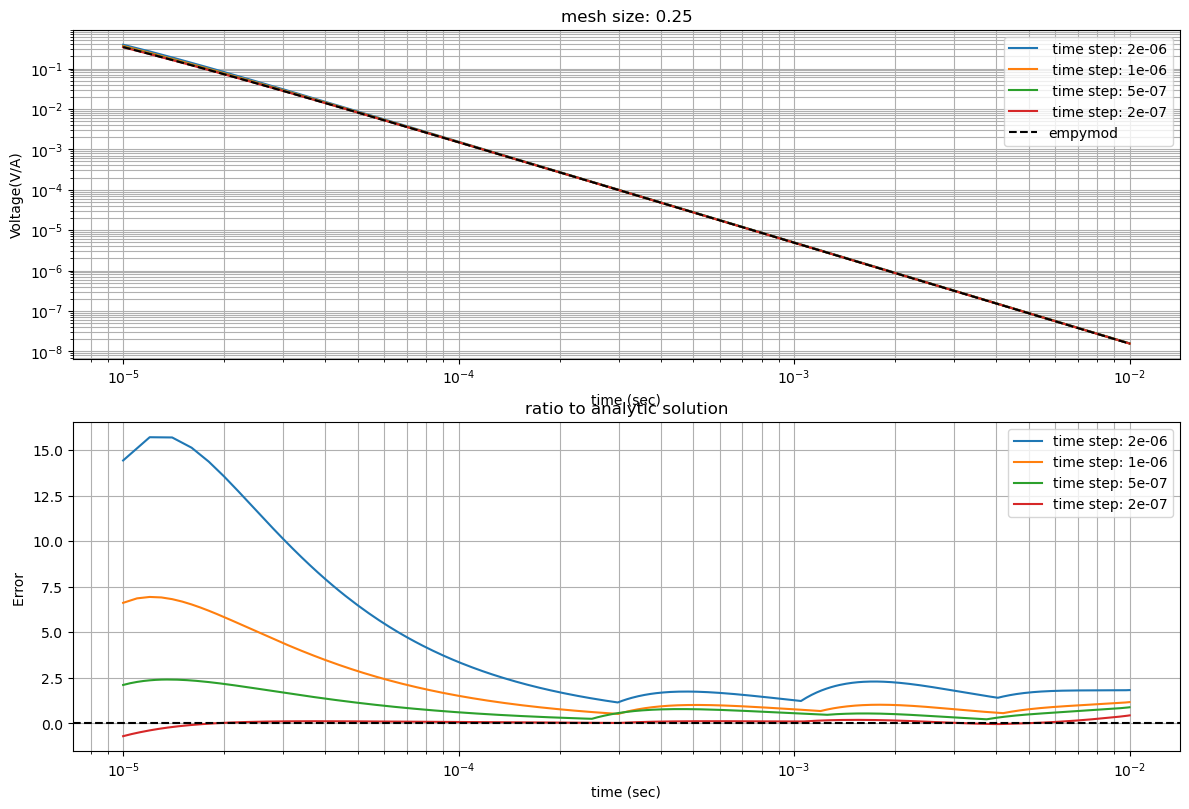

In [27]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
istrt = mcount-m_tstp
#for i in np.arange(m_tstp) + istrt:
for i in np.arange(4) + istrt:
    ax[0].loglog(cnv_time[i], cnv_dpred[i], label = f" time step: {cnv_time_step[i]:.0e}")
ax[0].loglog(time_empymod, empymod_dpred,'k--',label = "empymod")
ax[0].set_ylabel("Voltage(V/A)")
ax[0].set_title(f"mesh size: {cnv_csx[istrt]:.2f}")
#for i in np.arange(m_tstp) + istrt:
for i in np.arange(4) + istrt:
    ax[1].semilogx(cnv_time[i],(cnv_dpred[i]/analytic(cnv_time[i])-1)*100, label = f"time step: {cnv_time_step[i]:.0e}")
ax[1].set_title("ratio to analytic solution")
ax[1].axhline(y=0, color='k', linestyle='--')
ax[1].set_ylabel("Error ")
plt.tight_layout()
for a in ax:
    a.legend()
    a.set_xlabel("time (sec)")
    a.grid(True, which='both')

## Mesh size 4

In [28]:
csx, csz = tx_radius/10.,tx_radius/10.
ncx, ncz  = 250, 250 
pf, npadx, npadz = 1.3 , 30, 30
mesh = discretize.CylindricalMesh(
    [[(csx, ncx), (csx, npadx, pf)], [np.pi*2], [(csz, npadz, -pf), (csz, 2*ncz), (csz, npadz, pf)]], 
    origin = "000"
)
mesh.origin = np.r_[0, 0, -mesh.h[2][:npadz+ncz].sum()]
print(f"Cell size: {csx}, number of cells in center: {ncx}")

Cell size: 0.19746635424171471, number of cells in center: 250


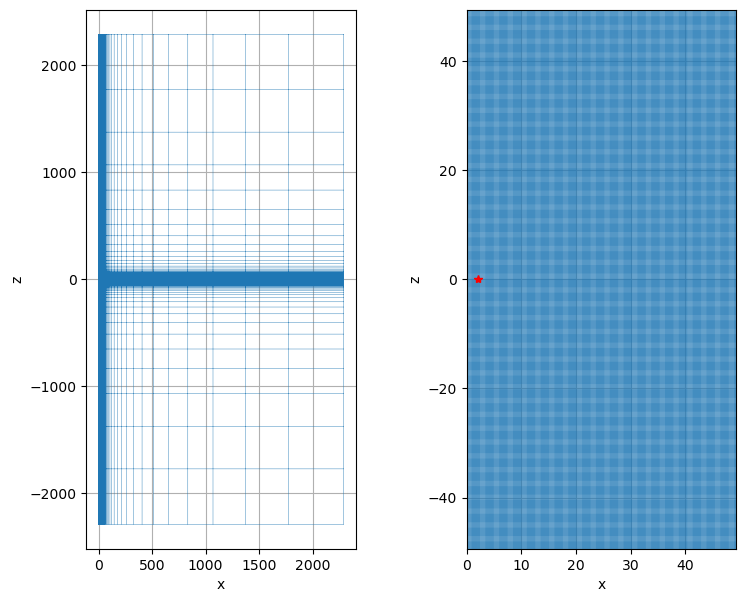

In [29]:
fig, ax = plt.subplots(1,2, figsize=(9,7))
ax[0] = mesh.plot_grid(ax=ax[0], show_it=False, linewidth=0.3)  
ax[0].set_aspect('equal')
ax[1] =  mesh.plot_grid(ax=ax[1], show_it=False, linewidth=0.3)
#ax[1] =  mesh.plot_grid(show_it=True)
ax[1].set_xlim(0.,ncx*csx)
ax[1].set_ylim(-ncz*csz,ncz*csz)
ax[1].set_aspect('equal')
ax[1].plot(tx_radius,0,'r*')

In [30]:
for i in range(m_tstp):
    print("time step", time_steps[i])
    start_time = time.time()
    dpred_time, dpred_simpeg = conv_study(mesh,time_steps[i])
    end_time = time.time()
    elapsed_time = end_time - start_time
    # Print the computational time
    print(f"Computational time: {elapsed_time:.4f} seconds")
    cnv_csx.append(csx)
    cnv_time_step.append(time_steps[i][0][0])
    cnv_time.append(dpred_time)
    cnv_dpred.append(dpred_simpeg)
mcount += m_tstp

time step [(2e-06, 150), (5e-06, 150), (2e-05, 150), (5e-05, 150)]
Computational time: 128.9783 seconds
time step [(1e-06, 300), (3e-06, 300), (1e-05, 300), (3e-05, 300)]
Computational time: 250.3132 seconds
time step [(5e-07, 500), (2e-06, 500), (5e-06, 500), (2e-05, 500)]
Computational time: 458.1471 seconds
time step [(2e-07, 1500), (5e-07, 1500), (2e-06, 1500), (5e-06, 1500)]
Computational time: 2171.1181 seconds


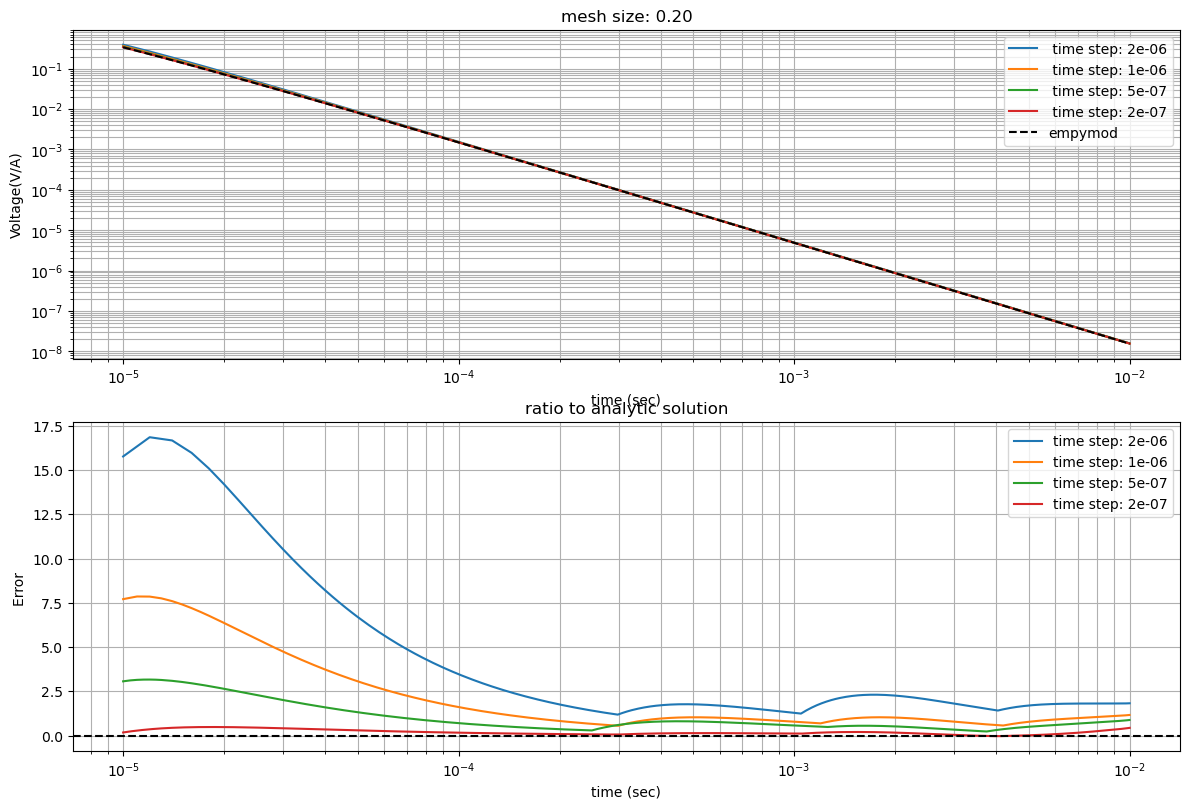

In [31]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
istrt = mcount-m_tstp
for i in np.arange(m_tstp) + istrt:
    ax[0].loglog(cnv_time[i], cnv_dpred[i], label = f" time step: {cnv_time_step[i]:.0e}")
ax[0].loglog(time_empymod, empymod_dpred,'k--',label = "empymod")
ax[0].set_ylabel("Voltage(V/A)")
ax[0].set_title(f"mesh size: {cnv_csx[istrt]:.2f}")
for i in np.arange(m_tstp) + istrt:
    ax[1].semilogx(cnv_time[i],(cnv_dpred[i]/analytic(cnv_time[i])-1)*100, label = f"time step: {cnv_time_step[i]:.0e}")
ax[1].set_title("ratio to analytic solution")
ax[1].axhline(y=0, color='k', linestyle='--')
ax[1].set_ylabel("Error ")
plt.tight_layout()
for a in ax:
    a.legend()
    a.set_xlabel("time (sec)")
    a.grid(True, which='both')

## Comparison between mesh size

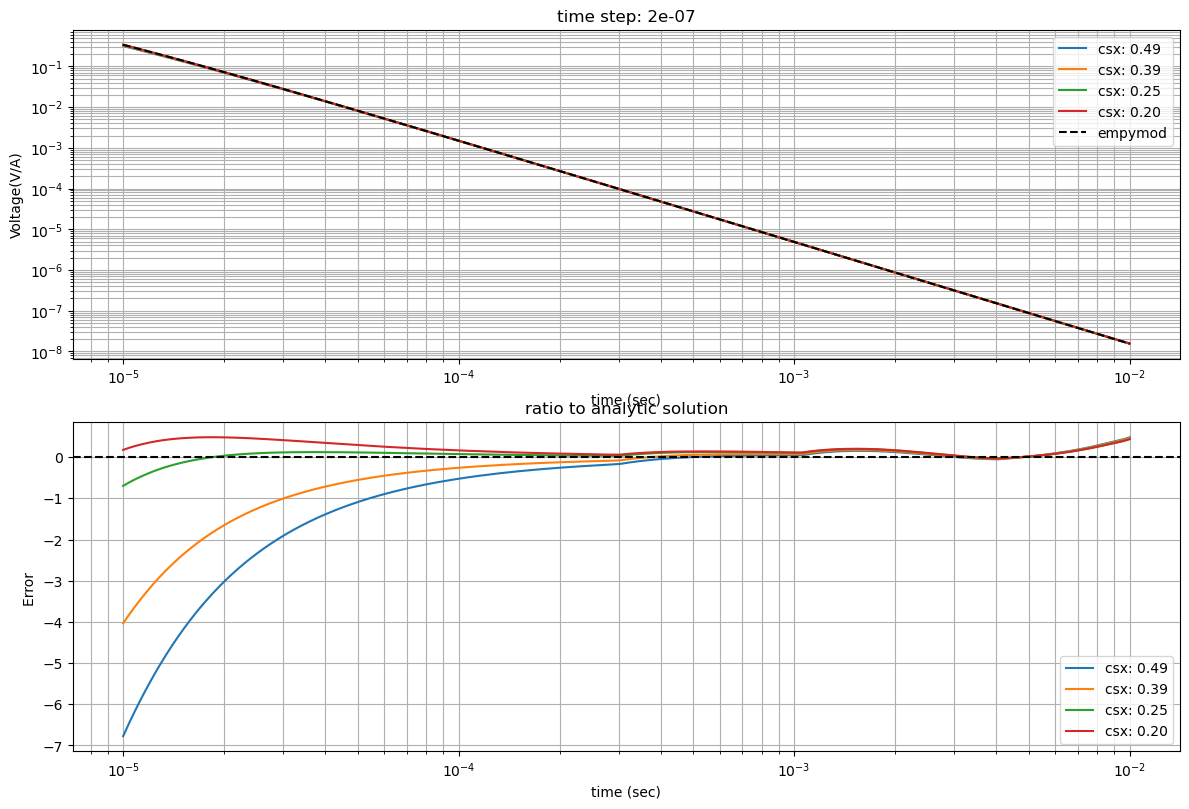

In [32]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
istrt = 3
istep = m_tstp
istop = mcount # 20
for i in np.arange(istrt,istop, istep):
    ax[0].loglog(cnv_time[i], cnv_dpred[i], label = f"csx: {cnv_csx[i]:.2f}")
ax[0].loglog(time_empymod, empymod_dpred,'k--',label = "empymod")
ax[0].set_ylabel("Voltage(V/A)")
ax[0].set_title(f"time step: {cnv_time_step[istrt]:.0e}")
for i in np.arange(istrt,istop, istep):
    ax[1].semilogx(cnv_time[i],(cnv_dpred[i]/analytic(cnv_time[i])-1)*100,  label = f"csx: {cnv_csx[i]:.2f}")
ax[1].set_title("ratio to analytic solution")
ax[1].axhline(y=0, color='k', linestyle='--')
ax[1].set_ylabel("Error ")
plt.tight_layout()
for a in ax:
    a.legend()
    a.set_xlabel("time (sec)")
    a.grid(True, which='both')

## Plot the result of Convervgence study

In [50]:
## Error between analytic and simpeg
err_abs = np.zeros(mcount)
err_rate = np.zeros(mcount)
#for i in range(m_csx):
for i in range(mcount):
    err_abs[i]  = np.max(np.abs(cnv_dpred[i]-analytic(cnv_time[i])))
    err_rate[i] = np.max(np.abs(cnv_dpred[i]/analytic(cnv_time[i])-1))


In [51]:
print(err_abs)
print(err_rate)

[0.01797958 0.00305494 0.01524982 0.02298343 0.03188776 0.00857938
 0.00513785 0.0136866  0.04899039 0.02247059 0.00717341 0.00236612
 0.05347199 0.02614088 0.01039646 0.00081535]
[0.0943814  0.02311007 0.04495147 0.06774763 0.1203474  0.04016359
 0.01514469 0.0403436  0.15716691 0.06946869 0.02412926 0.00697456
 0.16848269 0.07855533 0.03164316 0.00484478]


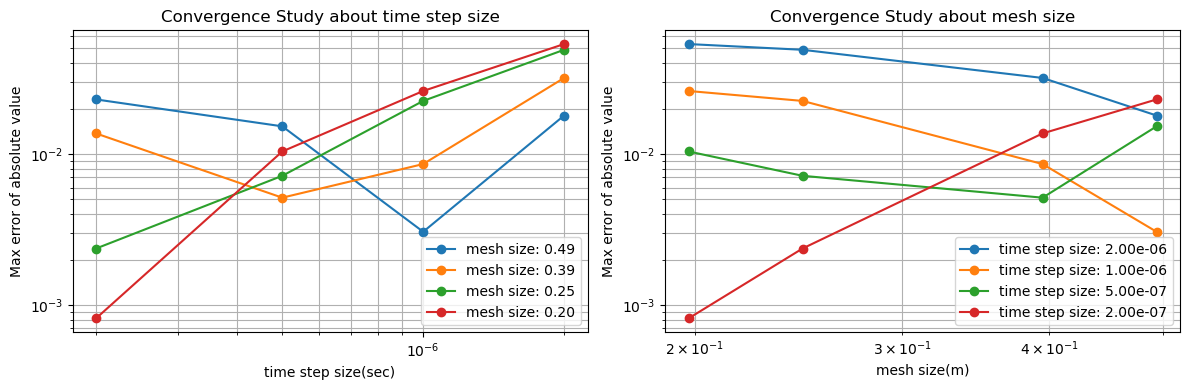

In [52]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(12, 4))

# plot convergence study for time step size 
#err_min = np.min(err_matrix[err_matrix>0])
m_csx=4
for i in range (m_csx):
    istrt = i*m_tstp
    ax[0].loglog(cnv_time_step[istrt:istrt+m_tstp], err_abs[istrt:istrt+m_tstp], 'o-', label = f"mesh size: {cnv_csx[istrt]:.2f}")
#ax[0].loglog(t_sizes, err_min*(t_sizes/np.min(t_sizes)), 'k--', label = "1st order")
ax[0].set_xlabel("time step size(sec)")
ax[0].set_title("Convergence Study about time step size")


# plot convergence study for spatial mesh size 
for i in range(m_tstp):
    istrt = i
    ax[1].loglog(cnv_csx[istrt:mcount:m_tstp], err_abs[istrt:mcount:m_tstp], 'o-', label = f"time step size: {cnv_time_step[istrt]:.2e}")
#ax[1].loglog(h_sizes, err_min*((h_sizes/np.min(h_sizes))**2), 'k--', label = "2nd order")
ax[1].set_xlabel("mesh size(m)")
ax[1].set_title("Convergence Study about mesh size")

for a in ax:
    a.grid(True, which='both')
    a.legend()
    a.set_ylabel("Max error of absolute value")
plt.tight_layout()


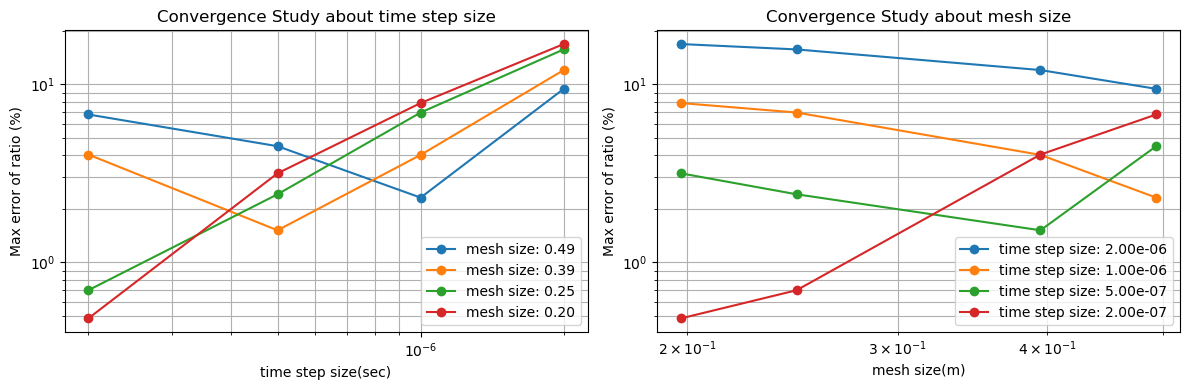

In [53]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(12, 4))

# plot convergence study for time step size 
#err_min = np.min(err_matrix[err_matrix>0])
m_csx=4
for i in range (m_csx):
    istrt = i*m_tstp
    ax[0].loglog(cnv_time_step[istrt:istrt+m_tstp], 100*err_rate[istrt:istrt+m_tstp], 'o-', label = f"mesh size: {cnv_csx[istrt]:.2f}")
#ax[0].loglog(t_sizes, err_min*(t_sizes/np.min(t_sizes)), 'k--', label = "1st order")
ax[0].set_xlabel("time step size(sec)")
ax[0].set_title("Convergence Study about time step size")


# plot convergence study for spatial mesh size 
for i in range(m_tstp):
    istrt = i
    ax[1].loglog(cnv_csx[istrt:mcount:m_tstp], 100*err_rate[istrt:mcount:m_tstp], 'o-', label = f"time step size: {cnv_time_step[istrt]:.2e}")
#ax[1].loglog(h_sizes, err_min*((h_sizes/np.min(h_sizes))**2), 'k--', label = "2nd order")
ax[1].set_xlabel("mesh size(m)")
ax[1].set_title("Convergence Study about mesh size")

for a in ax:
    a.grid(True, which='both')
    a.legend()
    a.set_ylabel("Max error of ratio (%)")
plt.tight_layout()


## Plot some of best result

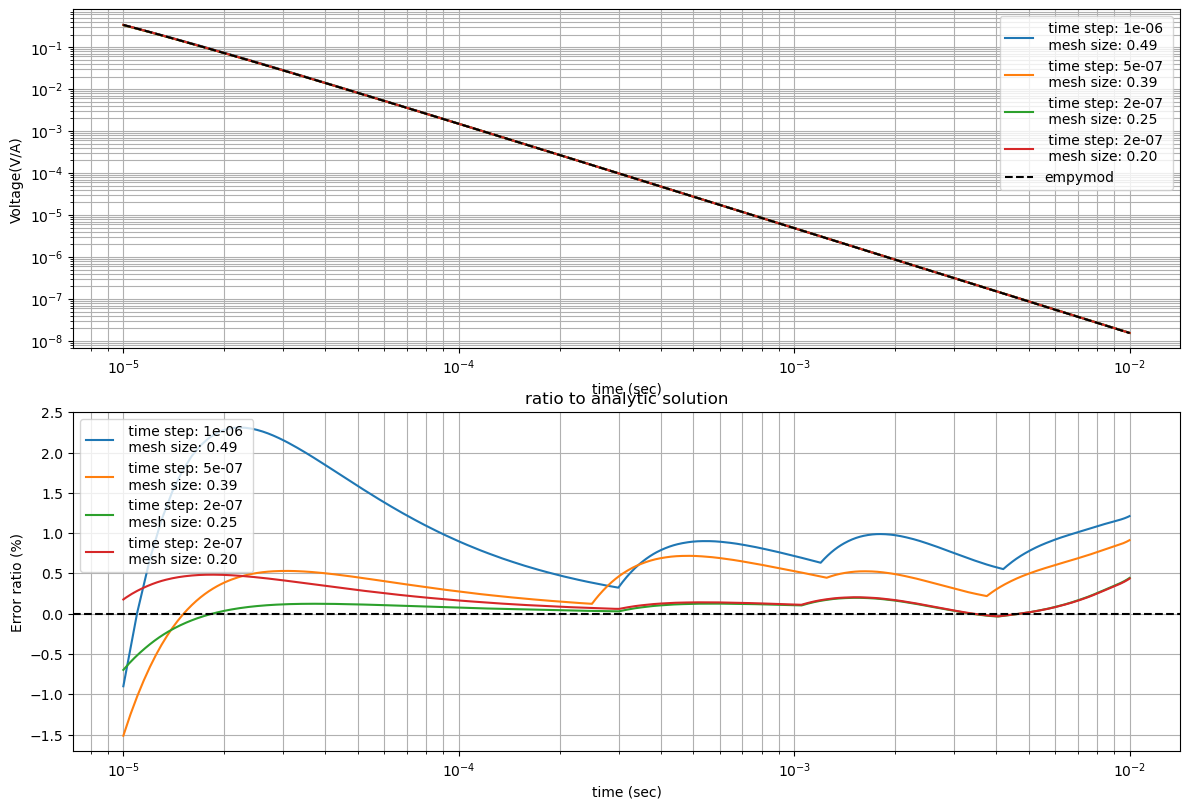

In [49]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
index_plot = np.r_[1,6,11,15]
for i in index_plot:
    ax[0].loglog(cnv_time[i], cnv_dpred[i], label = f" time step: {cnv_time_step[i]:.0e} \n mesh size: {cnv_csx[i]:.2f}")
ax[0].loglog(time_empymod, empymod_dpred,'k--',label = "empymod")
ax[0].set_ylabel("Voltage(V/A)")
for i in index_plot:
    ax[1].semilogx(cnv_time[i],(cnv_dpred[i]/analytic(cnv_time[i])-1)*100, label = f" time step: {cnv_time_step[i]:.0e} \n mesh size: {cnv_csx[i]:.2f}")
ax[1].set_title("ratio to analytic solution")
ax[1].axhline(y=0, color='k', linestyle='--')
ax[1].set_ylabel("Error ratio (%)")
plt.tight_layout()
for a in ax:
    a.legend()
    a.set_xlabel("time (sec)")
    a.grid(True, which='both')